<a href="https://colab.research.google.com/github/Shreya-spec/Voice-Authentication-/blob/main/Privacy_Protection_with_Voice_Authentication_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING THE DIFFERENT LIBRARY

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Ravdess="/content/drive/MyDrive/Dataset"

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + "/" + dir)
    for file in actor:
        part = file.split('.')[0]
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(part)
        file_path.append(Ravdess + '/' + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Person'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

In [5]:
data_path = pd.concat([emotion_df, path_df], axis=1)
data_path.head()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Person,Path
0,02,/content/drive/MyDrive/Dataset/Target_02/02.1.wav
1,02,/content/drive/MyDrive/Dataset/Target_02/02.2.wav
2,02,/content/drive/MyDrive/Dataset/Target_02/02.3.wav
3,02,/content/drive/MyDrive/Dataset/Target_02/02.6.wav
4,02,/content/drive/MyDrive/Dataset/Target_02/02.7.wav


In [6]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} person'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} person'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

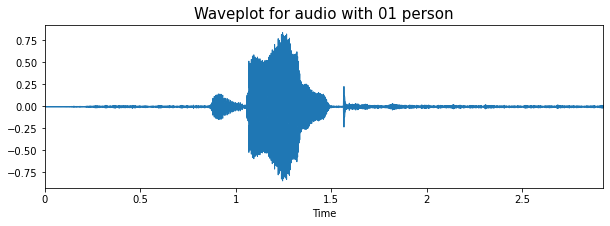

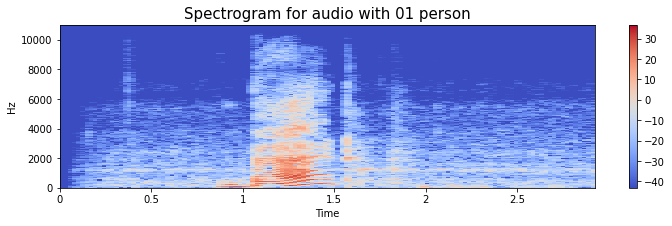

In [7]:
person='01'
path = np.array(data_path.Path[data_path.Person==person])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, person)
create_spectrogram(data, sampling_rate, person)
Audio(path)

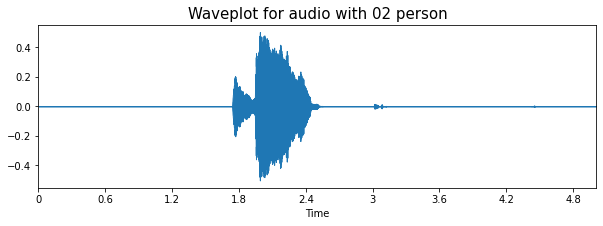

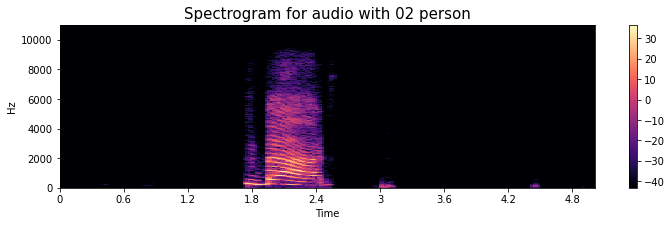

In [8]:
person='02'
path = np.array(data_path.Path[data_path.Person==person])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, person)
create_spectrogram(data, sampling_rate, person)
Audio(path)

In [9]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path[data_path.Person==person])[1]
data, sample_rate = librosa.load(path)

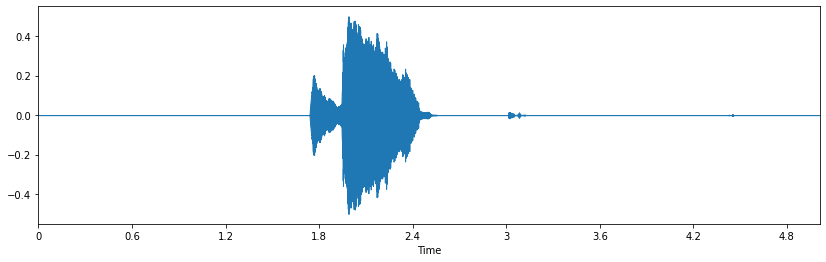

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

In [12]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [13]:
X, Y = [], []
for path, person in zip(data_path.Path, data_path.Person):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        if person=='01':
           Y.append('Male')
        elif person=='03':
           Y.append('Telephonic Male')
        elif person=='04':
           Y.append('Telephonic Female')
        else:
           Y.append('Female')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [14]:
len(X), len(Y), data_path.Path.shape

(1800, 1800, (600,))

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.503857,0.760832,0.773479,0.808155,0.685710,0.593227,0.608599,0.648907,0.631211,0.635721,...,3.816031e-07,5.472950e-07,2.445634e-06,2.687578e-07,8.615218e-08,2.162782e-07,8.593938e-08,1.393273e-09,1.300090e-11,Female
1,0.396132,0.775181,0.768246,0.778900,0.805857,0.829194,0.799228,0.771413,0.760228,0.720583,...,5.347507e-05,4.885569e-05,5.075289e-05,4.781472e-05,4.721847e-05,4.988005e-05,5.021791e-05,5.008127e-05,4.901705e-05,Female
2,0.357943,0.782265,0.769923,0.740454,0.719748,0.590021,0.593597,0.613607,0.659929,0.635634,...,5.386624e-08,1.657744e-07,9.510268e-08,4.981183e-07,4.750098e-07,1.547179e-08,4.694475e-09,1.995468e-09,3.436966e-12,Female
3,0.395331,0.738102,0.754809,0.764882,0.709294,0.592919,0.512946,0.516122,0.572241,0.604195,...,3.716979e-05,1.328926e-05,9.379356e-06,1.711616e-06,2.591061e-07,4.920498e-08,3.998696e-09,2.504640e-10,8.876089e-12,Female
4,0.326986,0.743310,0.763622,0.779752,0.753798,0.739274,0.685031,0.599040,0.606537,0.636386,...,3.760056e-05,1.355938e-05,9.681247e-06,2.024965e-06,5.172116e-07,3.191162e-07,2.812691e-07,2.766037e-07,2.710574e-07,Female


In [16]:
df = pd.read_csv('/content/features.csv')

In [17]:
df.isnull().sum()

0         0
1         0
2         0
3         0
4         0
         ..
158       0
159       0
160       0
161       0
labels    0
Length: 163, dtype: int64

In [18]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [19]:
x = df.iloc[:,:-1]
y = df.labels

In [20]:


x.head()



,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.503857,0.760832,0.773479,0.808155,0.685710,0.593227,0.608599,0.648907,0.631211,0.635721,...,3.912926e-07,3.816031e-07,5.472950e-07,2.445634e-06,2.687578e-07,8.615218e-08,2.162782e-07,8.593938e-08,1.393273e-09,1.300090e-11
1,0.396132,0.775181,0.768246,0.778900,0.805857,0.829194,0.799228,0.771413,0.760228,0.720583,...,4.974816e-05,5.347507e-05,4.885569e-05,5.075289e-05,4.781472e-05,4.721847e-05,4.988005e-05,5.021791e-05,5.008127e-05,4.901705e-05
2,0.357943,0.782265,0.769923,0.740454,0.719748,0.590021,0.593597,0.613607,0.659929,0.635634,...,6.281045e-09,5.386624e-08,1.657744e-07,9.510268e-08,4.981183e-07,4.750098e-07,1.547179e-08,4.694475e-09,1.995468e-09,3.436966e-12
3,0.395331,0.738102,0.754809,0.764882,0.709294,0.592919,0.512946,0.516122,0.572241,0.604195,...,9.726635e-05,3.716979e-05,1.328926e-05,9.379356e-06,1.711616e-06,2.591061e-07,4.920498e-08,3.998696e-09,2.504640e-10,8.876089e-12
4,0.326986,0.743310,0.763622,0.779752,0.753798,0.739274,0.685031,0.599040,0.606537,0.636386,...,9.793636e-05,3.760056e-05,1.355938e-05,9.681247e-06,2.024965e-06,5.172116e-07,3.191162e-07,2.812691e-07,2.766037e-07,2.710574e-07


In [21]:


y.head()



0    Female
1    Female
2    Female
3    Female
4    Female
Name: labels, dtype: object

In [22]:


df['labels'].value_counts()



Female               450
Telephonic Male      450
Telephonic Female    450
Male                 450
Name: labels, dtype: int64

In [23]:
data = ['Female','Male', 'Telephonic Male', 'Telephonic Female']
d= [450,450,450,450]

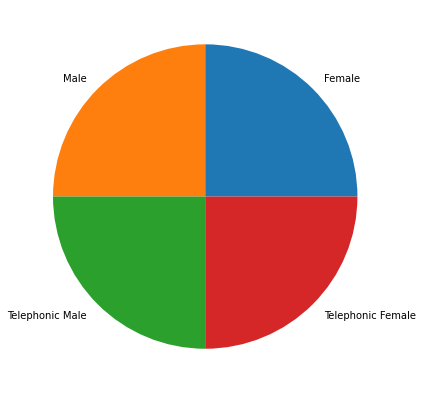

In [24]:
fig = plt.figure(figsize =(10, 7))
plt.pie(d, labels = data)
 
# show plot
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [26]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1440, 162), (1440,), (360, 162), (360,))

In [27]:
###1) Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

DTmodel = DecisionTreeClassifier(random_state = 1)
DTmodel.fit(x_train,y_train)



DecisionTreeClassifier(random_state=1)

In [28]:
y_pred1 = DTmodel.predict(x_test)
y_pred1 = np.array(y_pred1)

print(y_pred1[:10])



['Female' 'Telephonic Male' 'Telephonic Male' 'Telephonic Female' 'Female'
 'Female' 'Male' 'Telephonic Female' 'Telephonic Female'
 'Telephonic Female']


In [29]:
print('score of decision tree model is: ', DTmodel.score(x_test,y_test))

score of decision tree model is:  0.8805555555555555


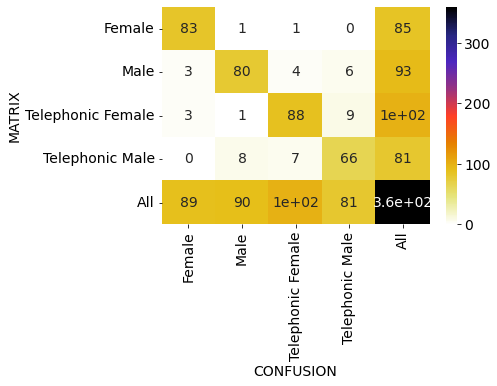

In [70]:
from sklearn.metrics import classification_report,accuracy_score

pd.crosstab(y_pred1,y_test,rownames=['matrix'],colnames=['confusion'],margins = True)
sns.heatmap(pd.DataFrame(pd.crosstab(y_pred1,y_test,rownames=['MATRIX'],colnames=['CONFUSION'],margins = True)),annot=True,cmap='CMRmap_r')


In [31]:


print("\t\t\tDecision Tree Class report:\n",classification_report(y_pred1,y_test))



			Decision Tree Class report:
                    precision    recall  f1-score   support

           Female       0.93      0.98      0.95        85
             Male       0.89      0.86      0.87        93
Telephonic Female       0.88      0.87      0.88       101
  Telephonic Male       0.81      0.81      0.81        81

         accuracy                           0.88       360
        macro avg       0.88      0.88      0.88       360
     weighted avg       0.88      0.88      0.88       360



In [32]:
print("Decision Tree Accuracy score: ",accuracy_score(y_pred1,y_test)*100,"%")

Decision Tree Accuracy score:  88.05555555555556 %


In [33]:
###2) Random Forest 

from sklearn.ensemble import RandomForestClassifier

RFmodel = RandomForestClassifier(random_state = 200)

RFmodel.fit(x_train,y_train)



RandomForestClassifier(random_state=200)

In [34]:
y_pred2 = RFmodel.predict(x_test)

In [35]:
print(y_pred2[:10])

['Female' 'Telephonic Male' 'Telephonic Male' 'Telephonic Female' 'Female'
 'Female' 'Male' 'Telephonic Female' 'Telephonic Female' 'Telephonic Male']


In [36]:
print('score of Random forest model is: ',RFmodel.score(x_test,y_test))

score of Random forest model is:  0.9416666666666667


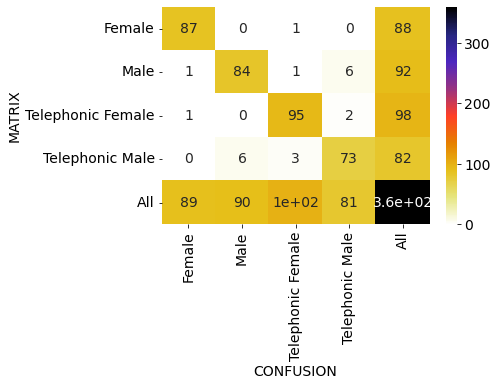

In [69]:
pd.crosstab(y_pred2,y_test,rownames=['matrix'],colnames=['confusion'],margins = True)
sns.heatmap(pd.DataFrame(pd.crosstab(y_pred2,y_test,rownames=['MATRIX'],colnames=['CONFUSION'],margins = True)),annot=True,cmap='CMRmap_r')

In [38]:
print("\t\t\tRandom Forest Class report:\n",classification_report(y_pred2,y_test))

			Random Forest Class report:
                    precision    recall  f1-score   support

           Female       0.98      0.99      0.98        88
             Male       0.93      0.91      0.92        92
Telephonic Female       0.95      0.97      0.96        98
  Telephonic Male       0.90      0.89      0.90        82

         accuracy                           0.94       360
        macro avg       0.94      0.94      0.94       360
     weighted avg       0.94      0.94      0.94       360



In [39]:
print("Random Forest Accuracy score: ",accuracy_score(y_pred2,y_test)*100,"%")

Random Forest Accuracy score:  94.16666666666667 %


In [40]:
# saving the model
import pickle
filename = 'random_forest_model.sav'
pickle.dump(RFmodel, open(filename, 'wb'))

In [41]:
###3)Logistic Regression

from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(max_iter=10000)

LRmodel.fit(x_train,y_train)



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=10000)

In [42]:
y_pred3 = LRmodel.predict(x_test)

print(y_pred3[:10])



['Female' 'Telephonic Male' 'Telephonic Male' 'Telephonic Female' 'Female'
 'Female' 'Male' 'Telephonic Female' 'Telephonic Female'
 'Telephonic Female']


In [43]:
print('score of Log Reg model is: ',LRmodel.score(x_test,y_test))

score of Log Reg model is:  0.925


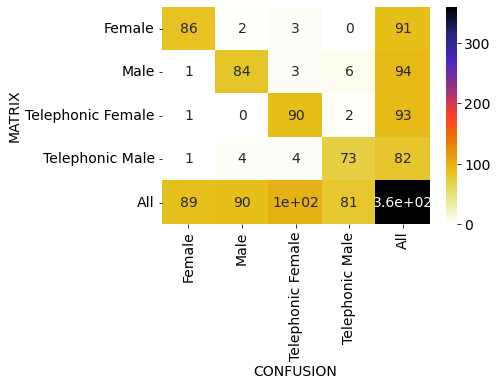

In [71]:


pd.crosstab(y_pred3,y_test,rownames=['matrix'],colnames=['confusion'],margins = True)
sns.heatmap(pd.DataFrame(pd.crosstab(y_pred3,y_test,rownames=['MATRIX'],colnames=['CONFUSION'],margins = True)),annot=True,cmap='CMRmap_r')


In [45]:


print("\t\t\tLog Reg Class report:\n",classification_report(y_pred2,y_test))



			Log Reg Class report:
                    precision    recall  f1-score   support

           Female       0.98      0.99      0.98        88
             Male       0.93      0.91      0.92        92
Telephonic Female       0.95      0.97      0.96        98
  Telephonic Male       0.90      0.89      0.90        82

         accuracy                           0.94       360
        macro avg       0.94      0.94      0.94       360
     weighted avg       0.94      0.94      0.94       360



In [46]:


print("Log Reg Accuracy score: ",accuracy_score(y_pred3,y_test)*100,"%")



Log Reg Accuracy score:  92.5 %


In [47]:
###4) KNN Classifier

from sklearn.neighbors import KNeighborsClassifier
KNmodel = KNeighborsClassifier(n_neighbors =15, metric = 'minkowski', p = 1)
KNmodel.fit(x_train, y_train)



KNeighborsClassifier(n_neighbors=15, p=1)

In [48]:
y_pred4 = KNmodel.predict(x_test)

y_pred4[:10]



array(['Female', 'Telephonic Male', 'Telephonic Male',
       'Telephonic Female', 'Female', 'Female', 'Male',
       'Telephonic Female', 'Telephonic Female', 'Telephonic Male'],
      dtype=object)

In [49]:
print('score of KNN model is: ', KNmodel.score(x_test,y_test))

score of KNN model is:  0.8972222222222223


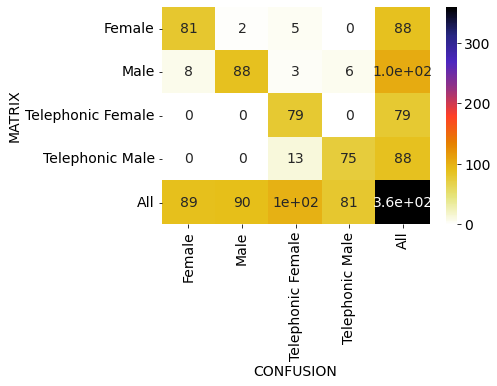

In [72]:
pd.crosstab(y_pred4,y_test,rownames=['matrix'],colnames=['confusion'],margins = True)
sns.heatmap(pd.DataFrame(pd.crosstab(y_pred4,y_test,rownames=['MATRIX'],colnames=['CONFUSION'],margins = True)),annot=True,cmap='CMRmap_r')

In [51]:
print("\t\t\tKNN report:\n",classification_report(y_pred4,y_test))

			KNN report:
                    precision    recall  f1-score   support

           Female       0.91      0.92      0.92        88
             Male       0.98      0.84      0.90       105
Telephonic Female       0.79      1.00      0.88        79
  Telephonic Male       0.93      0.85      0.89        88

         accuracy                           0.90       360
        macro avg       0.90      0.90      0.90       360
     weighted avg       0.91      0.90      0.90       360



In [52]:


print("KNN Accuracy score: ",accuracy_score(y_pred4,y_test)*100,"%")



KNN Accuracy score:  89.72222222222223 %


In [53]:
###5) SVM Model

from sklearn.svm import SVC

SVMmodel = SVC(kernel = 'linear')

SVMmodel.fit(x_train,y_train)



SVC(kernel='linear')

In [54]:
y_pred5 = SVMmodel.predict(x_test)

In [55]:
y_pred5[:10]

array(['Female', 'Telephonic Male', 'Telephonic Male',
       'Telephonic Female', 'Female', 'Female', 'Male',
       'Telephonic Female', 'Telephonic Female', 'Telephonic Female'],
      dtype=object)

In [56]:
print('score of SVM model is: ', SVMmodel.score(x_test,y_test))

score of SVM model is:  0.9


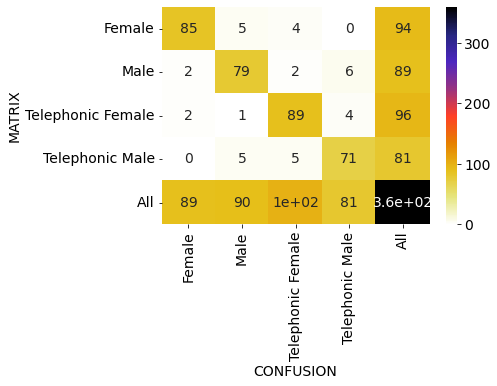

In [68]:


(pd.crosstab(y_pred5,y_test,rownames=['matrix'],colnames=['confusion'],margins = True))
sns.heatmap(pd.DataFrame(pd.crosstab(y_pred5,y_test,rownames=['MATRIX'],colnames=['CONFUSION'],margins = True)),annot=True,cmap='CMRmap_r')


In [59]:
print("\t\t\tSVM report:\n",classification_report(y_pred5,y_test))

			SVM report:
                    precision    recall  f1-score   support

           Female       0.96      0.90      0.93        94
             Male       0.88      0.89      0.88        89
Telephonic Female       0.89      0.93      0.91        96
  Telephonic Male       0.88      0.88      0.88        81

         accuracy                           0.90       360
        macro avg       0.90      0.90      0.90       360
     weighted avg       0.90      0.90      0.90       360



In [60]:
print("SVM Accuracy score: ",accuracy_score(y_pred5,y_test)*100,"%")

SVM Accuracy score:  90.0 %


In [61]:
list1 = [y_pred1,y_pred2,y_pred3,y_pred4,y_pred5]
d =['DecTree','RandomForest','Log Regression','KNN','SuppVecMachine']
a={} 
k=0
list2 = []
for i in list1:
    list2.append(accuracy_score(i,y_test)*100)
for i in d:
    a[i] = list2[k]
    k+=1
    

In [62]:
print("List of all model accuracies:\n",a)

List of all model accuracies:
 {'DecTree': 88.05555555555556, 'RandomForest': 94.16666666666667, 'Log Regression': 92.5, 'KNN': 89.72222222222223, 'SuppVecMachine': 90.0}


Text(0.5, 0, 'ACCURACY')

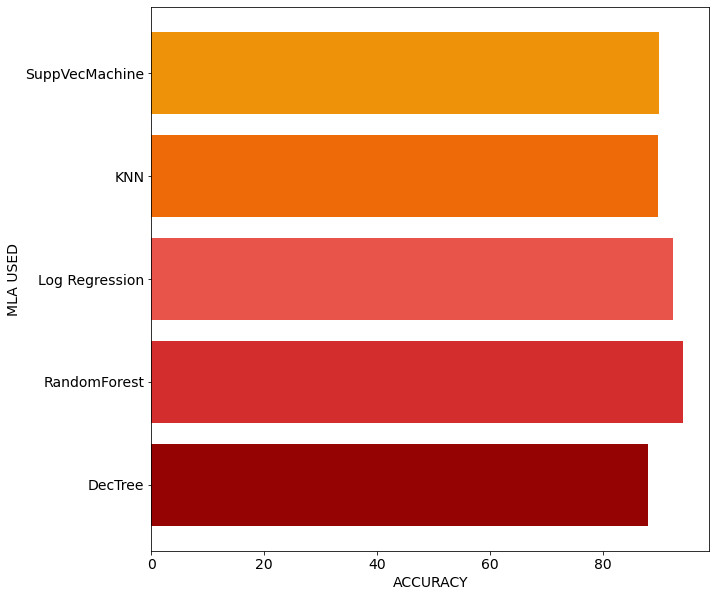

In [81]:
# Creating plot to show the train accuracy
#x= np.arange(5)
#xlabel("Accuracy Percentage")


plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 14})
plt.barh(d,list2,color=['#950303','#d32d2d','#e85449','#ee6a09','#ee9309'])
plt.ylabel('MLA USED')
plt.xlabel('ACCURACY')